Processing deteccion_vehiculos_20250328_142632.xlsx...
Detected Video ID: None
Loaded 96 vehicle detection records
Found 29 valid trajectories with sufficient movement

Identified direction clusters:
  Cluster 0: Direction_1 (angle: 61.0°)
  Cluster 1: Direction_3 (angle: 211.1°)
  Cluster 2: Direction_2 (angle: 113.1°)
  Cluster 3: Direction_4 (angle: 353.0°)


KeyboardInterrupt: 

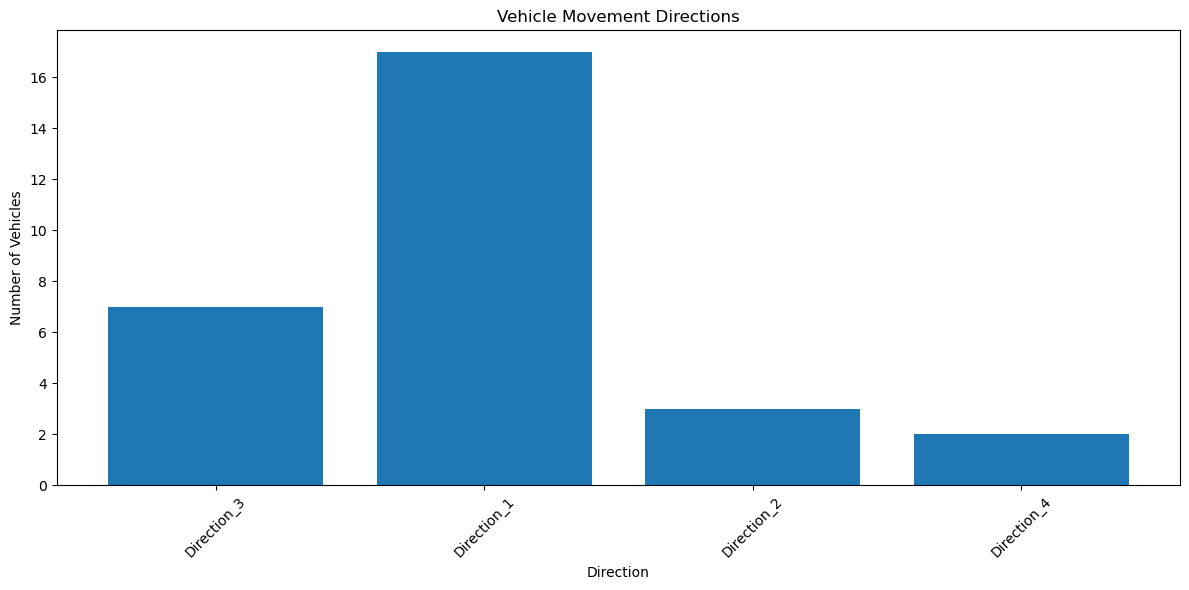

In [3]:
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

def load_vehicle_data(file_path, sheet_name="Datos_Detallados"):
    """Load vehicle data from Excel file."""
    # Read the sheet with detailed data
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Skip header row if it's duplicated
    if df.iloc[0]["ID"] == "ID":
        df = df.iloc[1:].reset_index(drop=True)
        
    # Convert ID to numeric if it's not already
    df["ID"] = pd.to_numeric(df["ID"])

    df.drop_duplicates(subset="ID", keep="last", inplace=True)
    
    return df

def parse_trajectory(trajectory_str):
    """Parse trajectory string into list of coordinate tuples."""
    # Extract all (x,y) coordinates from the trajectory string
    coordinates = re.findall(r'\((\d+),(\d+)\)', trajectory_str)
    
    # Convert to list of (x, y) tuples with integer values
    points = [(int(x), int(y)) for x, y in coordinates]
    
    return points

def calculate_trajectory_vector(points):
    """Calculate the direction vector of a trajectory."""
    if len(points) < 2:
        return None, None, None
    
    # Use first and last point for overall direction
    start_x, start_y = points[0]
    end_x, end_y = points[-1]
    
    # Calculate displacement vector
    dx = end_x - start_x
    dy = end_y - start_y
    
    # Calculate vector length (distance traveled)
    distance = math.sqrt(dx**2 + dy**2)
    
    # Calculate angle in degrees (0 = East, going counterclockwise)
    angle = math.degrees(math.atan2(dy, dx))
    
    # Normalize angle to 0-360 range
    if angle < 0:
        angle += 360
        
    return dx, dy, angle

def extract_trajectory_features(df):
    """Extract direction features from trajectories."""
    # Parse trajectories
    df['trajectory_points'] = df['Trayectoria'].apply(parse_trajectory)
    
    # Calculate direction features
    vectors = [calculate_trajectory_vector(points) for points in df['trajectory_points']]
    df['dx'] = [v[0] if v[0] is not None else 0 for v in vectors]
    df['dy'] = [v[1] if v[1] is not None else 0 for v in vectors]
    df['angle'] = [v[2] if v[2] is not None else -1 for v in vectors]
    
    # Calculate displacement distance
    df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2)
    
    # Filter out invalid trajectories (too short or no movement)
    min_displacement = 5  # Minimum pixel distance to consider valid movement
    df = df[df['distance'] > min_displacement].copy()
    
    return df

def cluster_directions(df, n_clusters=4):
    """Cluster vehicle trajectories into dominant directions."""
    # Get valid angles
    valid_angles = df[df['angle'] >= 0]['angle'].values
    
    if len(valid_angles) < n_clusters:
        print(f"Warning: Not enough valid trajectories. Found {len(valid_angles)}, need at least {n_clusters}")
        return None, None
    
    # Convert angles to x,y on unit circle for proper clustering
    x = np.cos(np.radians(valid_angles))
    y = np.sin(np.radians(valid_angles))
    
    # Combine into feature array
    features = np.column_stack((x, y))
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features)
    
    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    # Convert cluster centers back to angles
    cluster_angles = np.degrees(np.arctan2(centers[:, 1], centers[:, 0]))
    cluster_angles = np.mod(cluster_angles, 360)  # Normalize to 0-360
    
    # Function to assign angle to nearest cluster
    def find_nearest_cluster(angle):
        if angle < 0:
            return -1
        
        # Convert angle to point on unit circle
        x = np.cos(np.radians(angle))
        y = np.sin(np.radians(angle))
        
        # Find nearest cluster
        distances = [np.sqrt((x - cx)**2 + (y - cy)**2) for cx, cy in centers]
        return np.argmin(distances)
    
    # Assign each trajectory to a cluster
    df['direction_cluster'] = df['angle'].apply(find_nearest_cluster)
    
    return cluster_angles, df

def name_direction_clusters(cluster_angles, video_id=None):
    """Assign names to direction clusters based on their angles."""
    # Sort clusters by angle
    sorted_indices = np.argsort(cluster_angles)
    sorted_angles = cluster_angles[sorted_indices]
    
    # If video_id is provided, use it as prefix for direction names
    prefix = f"Video{video_id}_" if video_id is not None else ""
    
    if len(sorted_angles) == 4:
        # For 4 clusters, use main directions
        direction_names = [
            f"{prefix}Direction_1",
            f"{prefix}Direction_2",
            f"{prefix}Direction_3",
            f"{prefix}Direction_4"
        ]
    else:
        # For other cluster counts, just number them
        direction_names = [f"{prefix}Direction_{i+1}" for i in range(len(sorted_angles))]
    
    # Create mapping from cluster index to direction name
    cluster_to_name = {}
    for i, idx in enumerate(sorted_indices):
        cluster_to_name[idx] = direction_names[i]
    
    return cluster_to_name, sorted_angles

def assign_direction_names(df, cluster_to_name):
    """Assign descriptive direction names to trajectories."""
    # Create a mapping function
    def get_direction_name(cluster_idx):
        if cluster_idx < 0:
            return "Unknown"
        return cluster_to_name.get(cluster_idx, f"Direction_{cluster_idx}")
    
    # Apply mapping to create named direction column
    df['direction'] = df['direction_cluster'].apply(get_direction_name)
    
    return df

def extract_video_id(filename):
    """Try to extract video ID from filename."""
    # Look for patterns like video1, video_2, vid3, etc.
    match = re.search(r'video[_-]?(\d+)|vid[_-]?(\d+)', filename, re.IGNORECASE)
    if match:
        # Return the first non-None group
        return next(g for g in match.groups() if g is not None)
    
    return None

def process_vehicle_data(file_path, sheet_name="Datos_Detallados", n_clusters=4):
    """Process vehicle data and classify directions."""
    print(f"Processing {file_path}...")
    
    # Try to extract video ID from filename
    video_id = extract_video_id(file_path)
    print(f"Detected Video ID: {video_id if video_id else 'None'}")
    
    # Load data
    df = load_vehicle_data(file_path, sheet_name)
    print(f"Loaded {len(df)} vehicle detection records")
    
    # Extract trajectory features
    df = extract_trajectory_features(df)
    print(f"Found {len(df)} valid trajectories with sufficient movement")
    
    if len(df) < n_clusters:
        print(f"Warning: Not enough valid trajectories for clustering. Need at least {n_clusters}.")
        return df, None, None
    
    # Cluster directions
    cluster_angles, df = cluster_directions(df, n_clusters)
    
    if cluster_angles is None:
        print("Clustering failed. Not enough valid trajectories.")
        return df, None, None
    
    # Name clusters
    cluster_to_name, sorted_angles = name_direction_clusters(cluster_angles, video_id)
    
    # Assign direction names
    df = assign_direction_names(df, cluster_to_name)
    
    # Print cluster information
    print("\nIdentified direction clusters:")
    for cluster_idx, angle in enumerate(cluster_angles):
        name = cluster_to_name[cluster_idx]
        print(f"  Cluster {cluster_idx}: {name} (angle: {angle:.1f}°)")
    
    return df, cluster_angles, cluster_to_name

def visualize_directions(df, cluster_angles, cluster_to_name, file_path):
    """Visualize the direction clusters and trajectory data."""
    if cluster_angles is None or cluster_to_name is None:
        return
    
    # Create output filename
    base_filename = file_path.rsplit('.', 1)[0]
    
    # 1. Plot vehicle counts by direction
    direction_counts = Counter(df['direction'])
    
    plt.figure(figsize=(12, 6))
    directions = list(direction_counts.keys())
    counts = [direction_counts[d] for d in directions]
    
    plt.bar(directions, counts)
    plt.xlabel('Direction')
    plt.ylabel('Number of Vehicles')
    plt.title('Vehicle Movement Directions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{base_filename}_direction_counts.png")
    
    # 2. Plot trajectory angles on a polar chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, projection='polar')
    
    # Convert angles to radians for polar plot
    angles_rad = np.radians(df['angle'].values)
    
    # Plot each trajectory as a point
    ax.scatter(angles_rad, df['distance'].values, alpha=0.3, s=10)
    
    # Plot cluster centers
    for angle in cluster_angles:
        ax.scatter(np.radians(angle), 1.0, s=200, marker='*', color='red')
    
    # Customize polar plot
    ax.set_theta_zero_location('E')  # 0 degrees at East
    ax.set_theta_direction(-1)  # Clockwise
    plt.title('Vehicle Trajectory Angles')
    plt.tight_layout()
    plt.savefig(f"{base_filename}_angle_distribution.png")
    
    # 3. Plot actual trajectories in 2D space
    plt.figure(figsize=(12, 12))
    
    # Get a sample of trajectories (plot all if few, sample if many)
    sample_size = min(len(df), 100)
    if len(df) > sample_size:
        sample_df = df.sample(sample_size, random_state=42)
    else:
        sample_df = df
    
    # Create a colormap for different directions
    direction_to_color = {}
    colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_to_name)))
    for i, cluster_idx in enumerate(cluster_to_name.keys()):
        direction_to_color[cluster_to_name[cluster_idx]] = colors[i]
    
    # Add "Unknown" if present
    if "Unknown" in df['direction'].values:
        direction_to_color["Unknown"] = (0.7, 0.7, 0.7, 1.0)  # Gray
    
    # Extract trajectory coordinates and plot
    for _, row in sample_df.iterrows():
        points = row['trajectory_points']
        if len(points) >= 2:
            xs, ys = zip(*points)
            color = direction_to_color.get(row['direction'], (0, 0, 0))
            plt.plot(xs, ys, '-', alpha=0.5, linewidth=1, color=color)
            # Mark start with circle, end with arrow
            plt.plot(xs[0], ys[0], 'o', markersize=4, color=color)
            plt.arrow(xs[-2], ys[-2], 
                     xs[-1] - xs[-2], ys[-1] - ys[-2],
                     head_width=3, head_length=3, color=color)
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=color, lw=2, label=direction)
                      for direction, color in direction_to_color.items()]
    plt.legend(handles=legend_elements)
    
    plt.title('Vehicle Trajectories (Sample)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{base_filename}_trajectories.png")
    
    print(f"\nGenerated visualization files:")
    print(f"- {base_filename}_direction_counts.png: Vehicle counts by direction")
    print(f"- {base_filename}_angle_distribution.png: Polar plot of trajectory angles")
    print(f"- {base_filename}_trajectories.png: Sample of actual vehicle trajectories")

def main():
    """Main function to process vehicle data."""
    # File path
    file_path = "deteccion_vehiculos_20250328_142632.xlsx"
    
    try:
        # Process the data
        df, cluster_angles, cluster_to_name = process_vehicle_data(file_path, n_clusters=4)
        
        if df is not None:
            # Save the results to new sheets in the original Excel file
            with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
                # Create summary sheet with vehicle direction counts
                if cluster_to_name is not None:
                    # Get direction counts
                    direction_counts = Counter(df['direction'])
                    
                    # Create summary dataframe
                    summary_df = pd.DataFrame({
                        'Direction': list(direction_counts.keys()),
                        'VehicleCount': list(direction_counts.values()),
                    })
                    
                    # Sort by count (descending)
                    summary_df = summary_df.sort_values('VehicleCount', ascending=False)
                    
                    # Add percentages
                    total = summary_df['VehicleCount'].sum()
                    summary_df['Percentage'] = summary_df['VehicleCount'] / total * 100
                    
                    # Save to Excel
                    summary_df.to_excel(writer, sheet_name="Direction_Summary", index=False)
                    
                    # Also save cluster information
                    cluster_info = pd.DataFrame({
                        'Cluster': list(cluster_to_name.keys()),
                        'DirectionName': list(cluster_to_name.values()),
                        'Angle': [cluster_angles[i] for i in cluster_to_name.keys()]
                    })
                    cluster_info.to_excel(writer, sheet_name="Direction_Clusters", index=False)
                
                # Save full analyzed data
                df.to_excel(writer, sheet_name="Analyzed_Trajectories", index=False)
                
            # Create visualizations
            visualize_directions(df, cluster_angles, cluster_to_name, file_path)
            
            print("\nAnalysis complete!")
            print(f"Processed {len(df)} valid vehicle trajectories")
            print("\nResults added as new sheets to the original Excel file:")
            print("- Analyzed_Trajectories: Detailed trajectory analysis")
            print("- Direction_Summary: Vehicle counts by direction")
            print("- Direction_Clusters: Information about identified direction clusters")
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Processing deteccion_vehiculos_20250328_142632.xlsx...
File: deteccion_vehiculos_20250328_142632
Loaded 10136 vehicle detection records
After removing duplicates: 96 unique vehicles
Found 29 valid trajectories with sufficient movement
Determining optimal number of clusters...
  Testing 2 clusters: silhouette score = 0.6699
  Testing 3 clusters: silhouette score = 0.5450
  Testing 4 clusters: silhouette score = 0.6541
  Testing 5 clusters: silhouette score = 0.7308
  Optimal number of clusters: 5 (score: 0.7308)
Clustering with 5 clusters...

Identified direction clusters:
  Cluster 0: deteccion_vehiculos_20250328_142632_Direction_2 (angle: 113.1°, count: 3, 10.3%)
  Cluster 1: deteccion_vehiculos_20250328_142632_Direction_3 (angle: 185.5°, count: 4, 13.8%)
  Cluster 2: deteccion_vehiculos_20250328_142632_Direction_5 (angle: 353.0°, count: 2, 6.9%)
  Cluster 3: deteccion_vehiculos_20250328_142632_Direction_4 (angle: 246.0°, count: 3, 10.3%)
  Cluster 4: deteccion_vehiculos_20250328_1426

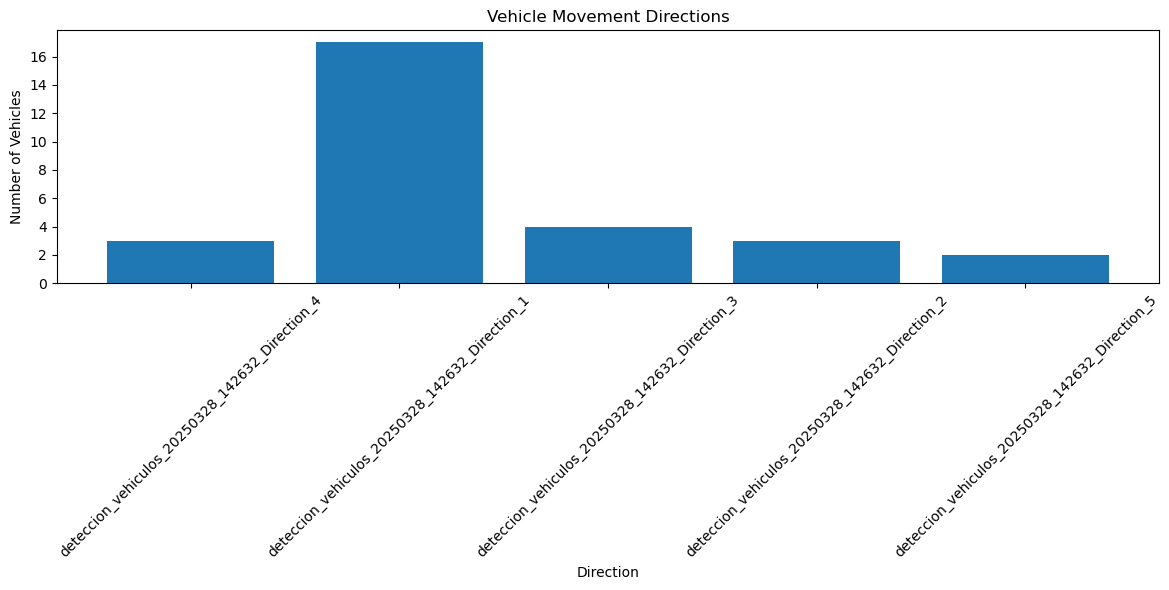

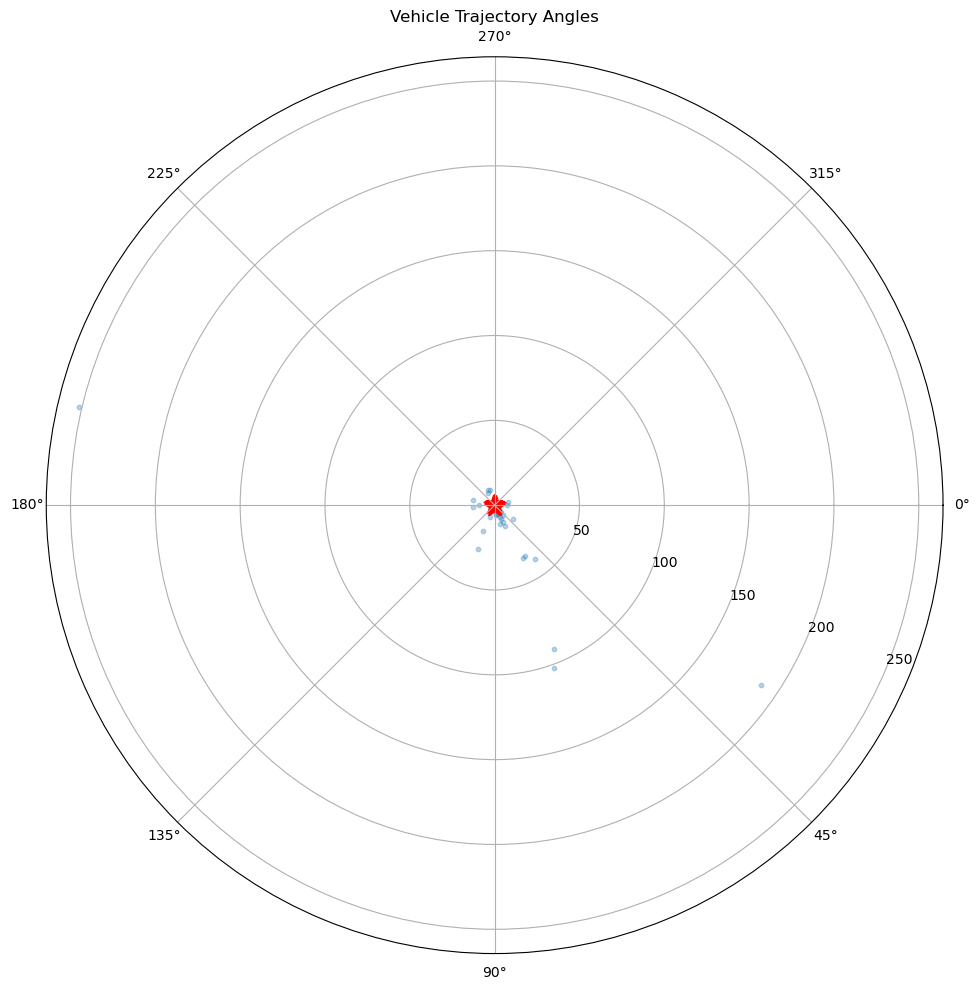

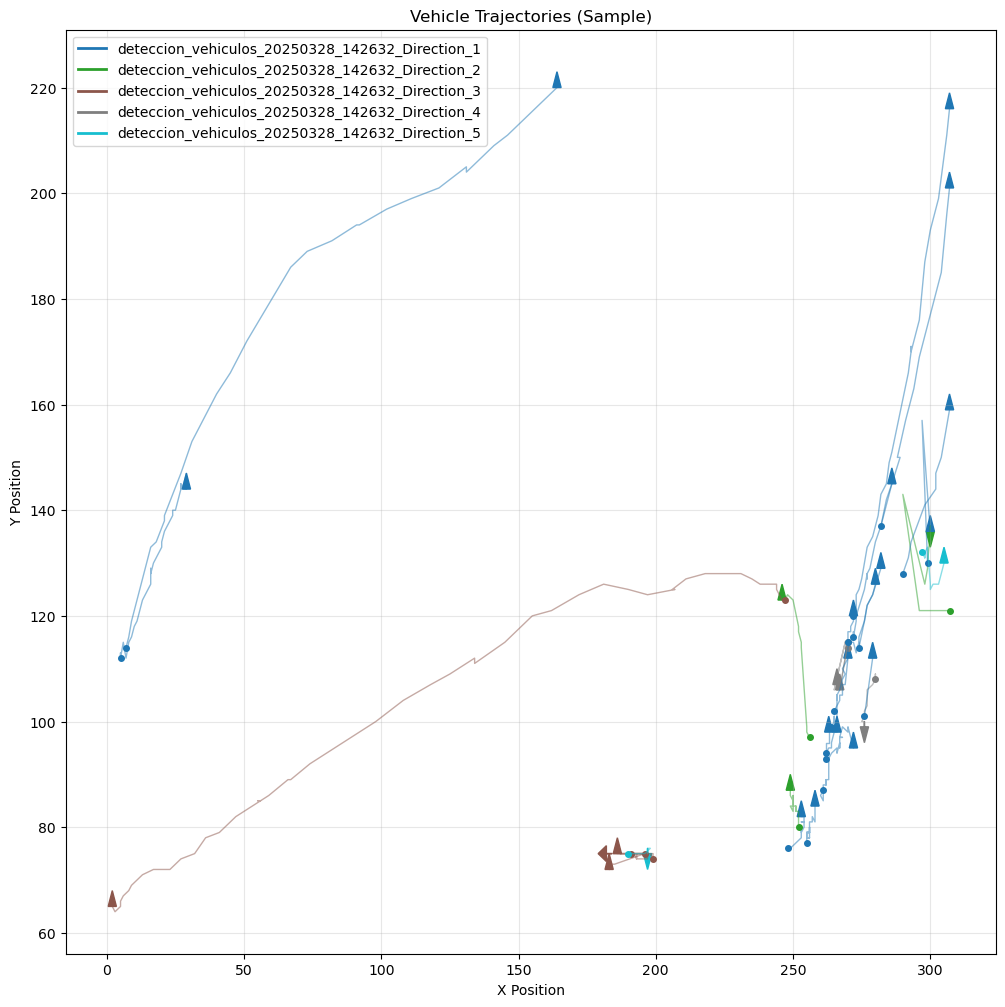

In [4]:
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
import os

def determine_optimal_clusters(angle_data, min_clusters=2, max_clusters=6):
    """
    Determine optimal number of clusters using silhouette score.
    This helps find the natural groupings in the data.
    """
    if len(angle_data) < max_clusters:
        return min(len(angle_data), min_clusters)
    
    # Convert angles to points on a unit circle for proper clustering
    x = np.cos(np.radians(angle_data))
    y = np.sin(np.radians(angle_data))
    
    # Combine into feature array
    features = np.column_stack((x, y))
    
    best_score = -1
    best_n_clusters = min_clusters
    
    # Try different cluster counts and find the best one
    for n_clusters in range(min_clusters, min(max_clusters + 1, len(angle_data))):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        
        # Calculate silhouette score
        try:
            score = silhouette_score(features, cluster_labels)
            print(f"  Testing {n_clusters} clusters: silhouette score = {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_n_clusters = n_clusters
        except:
            # If silhouette score fails (e.g., only one sample in cluster)
            continue
    
    print(f"  Optimal number of clusters: {best_n_clusters} (score: {best_score:.4f})")
    return best_n_clusters

def process_vehicle_data(file_path, sheet_name="Datos_Detallados", min_clusters=2, max_clusters=6, min_displacement=5):
    """Process vehicle data and classify directions with adaptive clustering."""
    print(f"Processing {file_path}...")
    
    # Try to extract video ID from filename
    video_id = os.path.splitext(os.path.basename(file_path))[0]
    print(f"File: {video_id}")
    
    # Load data
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None, None, None
    
    print(f"Loaded {len(df)} vehicle detection records")
    
    # Skip header row if it's duplicated
    if "ID" in df.columns and df.iloc[0]["ID"] == "ID":
        df = df.iloc[1:].reset_index(drop=True)
        
    # Convert ID to numeric if it's not already
    if "ID" in df.columns:
        df["ID"] = pd.to_numeric(df["ID"])
        # Keep only the last record for each vehicle (final trajectory)
        df.drop_duplicates(subset="ID", keep="last", inplace=True)
        print(f"After removing duplicates: {len(df)} unique vehicles")
    
    # Extract trajectory features
    try:
        # Find trajectory column
        traj_col = None
        for col in df.columns:
            if 'trayectoria' in col.lower() or 'trajectory' in col.lower():
                traj_col = col
                break
        
        if not traj_col:
            print("Error: Could not find trajectory column")
            return None, None, None
        
        # Parse trajectories
        df['trajectory_points'] = df[traj_col].apply(parse_trajectory)
        
        # Calculate direction features
        vectors = [calculate_trajectory_vector(points) for points in df['trajectory_points']]
        df['dx'] = [v[0] if v[0] is not None else 0 for v in vectors]
        df['dy'] = [v[1] if v[1] is not None else 0 for v in vectors]
        df['angle'] = [v[2] if v[2] is not None else -1 for v in vectors]
        
        # Calculate displacement distance
        df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2)
        
        # Filter out invalid trajectories (too short or no movement)
        valid_df = df[df['distance'] > min_displacement].copy()
        print(f"Found {len(valid_df)} valid trajectories with sufficient movement")
        
        if len(valid_df) < min_clusters:
            print(f"Warning: Not enough valid trajectories for clustering. Need at least {min_clusters}.")
            return df, None, None
            
        # Get valid angles for clustering
        valid_angles = valid_df[valid_df['angle'] >= 0]['angle'].values
        
        # Determine optimal number of clusters
        print("Determining optimal number of clusters...")
        n_clusters = determine_optimal_clusters(valid_angles, min_clusters, max_clusters)
        
        # Perform clustering with optimal number of clusters
        print(f"Clustering with {n_clusters} clusters...")
        cluster_angles, valid_df = cluster_directions(valid_df, n_clusters)
        
        if cluster_angles is None:
            print("Clustering failed.")
            return df, None, None
        
        # Name clusters
        cluster_to_name, sorted_angles = name_direction_clusters(cluster_angles, video_id)
        
        # Assign direction names
        valid_df = assign_direction_names(valid_df, cluster_to_name)
        
        # Print cluster information
        print("\nIdentified direction clusters:")
        direction_counts = Counter(valid_df['direction'])
        for cluster_idx, angle in enumerate(cluster_angles):
            name = cluster_to_name[cluster_idx]
            count = direction_counts.get(name, 0)
            percent = (count / len(valid_df)) * 100 if len(valid_df) > 0 else 0
            print(f"  Cluster {cluster_idx}: {name} (angle: {angle:.1f}°, count: {count}, {percent:.1f}%)")
        
        # Check for potential overclusterng
        if n_clusters > 3:
            # Look for similar angles that might be the same direction
            for i in range(n_clusters):
                for j in range(i+1, n_clusters):
                    # Check if angles are within 30 degrees of each other
                    angle_diff = min(abs(cluster_angles[i] - cluster_angles[j]), 
                                    360 - abs(cluster_angles[i] - cluster_angles[j]))
                    if angle_diff < 30:
                        print(f"  Note: Clusters {i} and {j} have similar angles " 
                              f"({cluster_angles[i]:.1f}° and {cluster_angles[j]:.1f}°)")
                        print(f"  These might represent the same general direction")
        
        return valid_df, cluster_angles, cluster_to_name
        
    except Exception as e:
        print(f"Error in trajectory analysis: {e}")
        import traceback
        traceback.print_exc()
        return df, None, None

# The rest of your functions remain the same
def parse_trajectory(trajectory_str):
    """Parse trajectory string into list of coordinate tuples."""
    # Extract all (x,y) coordinates from the trajectory string
    coordinates = re.findall(r'\((\d+),(\d+)\)', trajectory_str)
    
    # Convert to list of (x, y) tuples with integer values
    points = [(int(x), int(y)) for x, y in coordinates]
    
    return points

def calculate_trajectory_vector(points):
    """Calculate the direction vector of a trajectory."""
    if len(points) < 2:
        return None, None, None
    
    # Use first and last point for overall direction
    start_x, start_y = points[0]
    end_x, end_y = points[-1]
    
    # Calculate displacement vector
    dx = end_x - start_x
    dy = end_y - start_y
    
    # Calculate vector length (distance traveled)
    distance = math.sqrt(dx**2 + dy**2)
    
    # Calculate angle in degrees (0 = East, going counterclockwise)
    angle = math.degrees(math.atan2(dy, dx))
    
    # Normalize angle to 0-360 range
    if angle < 0:
        angle += 360
        
    return dx, dy, angle

def cluster_directions(df, n_clusters=4):
    """Cluster vehicle trajectories into dominant directions."""
    # Get valid angles
    valid_angles = df[df['angle'] >= 0]['angle'].values
    
    if len(valid_angles) < n_clusters:
        print(f"Warning: Not enough valid trajectories. Found {len(valid_angles)}, need at least {n_clusters}")
        return None, None
    
    # Convert angles to x,y on unit circle for proper clustering
    x = np.cos(np.radians(valid_angles))
    y = np.sin(np.radians(valid_angles))
    
    # Combine into feature array
    features = np.column_stack((x, y))
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features)
    
    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    # Convert cluster centers back to angles
    cluster_angles = np.degrees(np.arctan2(centers[:, 1], centers[:, 0]))
    cluster_angles = np.mod(cluster_angles, 360)  # Normalize to 0-360
    
    # Function to assign angle to nearest cluster
    def find_nearest_cluster(angle):
        if angle < 0:
            return -1
        
        # Convert angle to point on unit circle
        x = np.cos(np.radians(angle))
        y = np.sin(np.radians(angle))
        
        # Find nearest cluster
        distances = [np.sqrt((x - cx)**2 + (y - cy)**2) for cx, cy in centers]
        return np.argmin(distances)
    
    # Assign each trajectory to a cluster
    df['direction_cluster'] = df['angle'].apply(find_nearest_cluster)
    
    return cluster_angles, df

def name_direction_clusters(cluster_angles, video_id=None):
    """Assign names to direction clusters based on their angles."""
    # Sort clusters by angle
    sorted_indices = np.argsort(cluster_angles)
    sorted_angles = cluster_angles[sorted_indices]
    
    # If video_id is provided, use it as prefix for direction names
    prefix = f"{video_id}_" if video_id is not None else ""
    
    # Create direction names based on number of clusters
    direction_names = [f"{prefix}Direction_{i+1}" for i in range(len(sorted_angles))]
    
    # Create mapping from cluster index to direction name
    cluster_to_name = {}
    for i, idx in enumerate(sorted_indices):
        cluster_to_name[idx] = direction_names[i]
    
    return cluster_to_name, sorted_angles

def assign_direction_names(df, cluster_to_name):
    """Assign descriptive direction names to trajectories."""
    # Create a mapping function
    def get_direction_name(cluster_idx):
        if cluster_idx < 0:
            return "Unknown"
        return cluster_to_name.get(cluster_idx, f"Direction_{cluster_idx}")
    
    # Apply mapping to create named direction column
    df['direction'] = df['direction_cluster'].apply(get_direction_name)
    
    return df

def main():
    """Main function to process vehicle data."""
    # File path
    file_path = "deteccion_vehiculos_20250328_142632.xlsx"
    
    try:
        # Process the data with adaptive clustering
        df, cluster_angles, cluster_to_name = process_vehicle_data(
            file_path, 
            min_clusters=2,  # Minimum number of clusters to consider
            max_clusters=5   # Maximum number of clusters to consider
        )
        
        if df is not None:
            # Save the results to new sheets in the original Excel file
            with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
                # Create summary sheet with vehicle direction counts
                if cluster_to_name is not None:
                    # Get direction counts
                    direction_counts = Counter(df['direction'])
                    
                    # Create summary dataframe
                    summary_df = pd.DataFrame({
                        'Direction': list(direction_counts.keys()),
                        'VehicleCount': list(direction_counts.values()),
                    })
                    
                    # Sort by count (descending)
                    summary_df = summary_df.sort_values('VehicleCount', ascending=False)
                    
                    # Add percentages
                    total = summary_df['VehicleCount'].sum()
                    summary_df['Percentage'] = summary_df['VehicleCount'] / total * 100
                    
                    # Save to Excel
                    summary_df.to_excel(writer, sheet_name="Direction_Summary", index=False)
                    
                    # Also save cluster information
                    cluster_info = pd.DataFrame({
                        'Cluster': list(cluster_to_name.keys()),
                        'DirectionName': list(cluster_to_name.values()),
                        'Angle': [cluster_angles[i] for i in cluster_to_name.keys()]
                    })
                    cluster_info.to_excel(writer, sheet_name="Direction_Clusters", index=False)
                
                # Save full analyzed data
                df.to_excel(writer, sheet_name="Analyzed_Trajectories", index=False)
                
            # Create visualizations
            visualize_directions(df, cluster_angles, cluster_to_name, file_path)
            
            print("\nAnalysis complete!")
            print(f"Processed {len(df)} valid vehicle trajectories")
            print("\nResults added as new sheets to the original Excel file:")
            print("- Analyzed_Trajectories: Detailed trajectory analysis")
            print("- Direction_Summary: Vehicle counts by direction")
            print("- Direction_Clusters: Information about identified direction clusters")
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()

# Include your visualize_directions function here
def visualize_directions(df, cluster_angles, cluster_to_name, file_path):
    """Visualize the direction clusters and trajectory data."""
    if cluster_angles is None or cluster_to_name is None:
        return
    
    # Create output filename
    base_filename = file_path.rsplit('.', 1)[0]
    
    # 1. Plot vehicle counts by direction
    direction_counts = Counter(df['direction'])
    
    plt.figure(figsize=(12, 6))
    directions = list(direction_counts.keys())
    counts = [direction_counts[d] for d in directions]
    
    plt.bar(directions, counts)
    plt.xlabel('Direction')
    plt.ylabel('Number of Vehicles')
    plt.title('Vehicle Movement Directions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{base_filename}_direction_counts.png")
    
    # 2. Plot trajectory angles on a polar chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, projection='polar')
    
    # Convert angles to radians for polar plot
    angles_rad = np.radians(df['angle'].values)
    
    # Plot each trajectory as a point
    ax.scatter(angles_rad, df['distance'].values, alpha=0.3, s=10)
    
    # Plot cluster centers
    for angle in cluster_angles:
        ax.scatter(np.radians(angle), 1.0, s=200, marker='*', color='red')
    
    # Customize polar plot
    ax.set_theta_zero_location('E')  # 0 degrees at East
    ax.set_theta_direction(-1)  # Clockwise
    plt.title('Vehicle Trajectory Angles')
    plt.tight_layout()
    plt.savefig(f"{base_filename}_angle_distribution.png")
    
    # 3. Plot actual trajectories in 2D space
    plt.figure(figsize=(12, 12))
    
    # Get a sample of trajectories (plot all if few, sample if many)
    sample_size = min(len(df), 100)
    if len(df) > sample_size:
        sample_df = df.sample(sample_size, random_state=42)
    else:
        sample_df = df
    
    # Create a colormap for different directions
    direction_to_color = {}
    colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_to_name)))
    for i, cluster_idx in enumerate(cluster_to_name.keys()):
        direction_to_color[cluster_to_name[cluster_idx]] = colors[i]
    
    # Add "Unknown" if present
    if "Unknown" in df['direction'].values:
        direction_to_color["Unknown"] = (0.7, 0.7, 0.7, 1.0)  # Gray
    
    # Extract trajectory coordinates and plot
    for _, row in sample_df.iterrows():
        points = row['trajectory_points']
        if len(points) >= 2:
            xs, ys = zip(*points)
            color = direction_to_color.get(row['direction'], (0, 0, 0))
            plt.plot(xs, ys, '-', alpha=0.5, linewidth=1, color=color)
            # Mark start with circle, end with arrow
            plt.plot(xs[0], ys[0], 'o', markersize=4, color=color)
            plt.arrow(xs[-2], ys[-2], 
                     xs[-1] - xs[-2], ys[-1] - ys[-2],
                     head_width=3, head_length=3, color=color)
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=color, lw=2, label=direction)
                      for direction, color in direction_to_color.items()]
    plt.legend(handles=legend_elements)
    
    plt.title('Vehicle Trajectories (Sample)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{base_filename}_trajectories.png")
    
    print(f"\nGenerated visualization files:")
    print(f"- {base_filename}_direction_counts.png: Vehicle counts by direction")
    print(f"- {base_filename}_angle_distribution.png: Polar plot of trajectory angles")
    print(f"- {base_filename}_trajectories.png: Sample of actual vehicle trajectories")

if __name__ == "__main__":
    main()